In [9]:
import numpy as np
import matplotlib.pyplot as plt
import psycopg2

import ipydatetime
import ipywidgets
from datetime import datetime, timezone

In [10]:
def get_timings(p):    
    m,b = np.polyfit([p[0,1],p[-1,1]], [0, p[-1,2]-p[0,2]], deg=1)

    timings = lambda x: 1e-9 * (m * x + b)  # seconds
    return timings

### SQL settings

In [11]:
# DBNAME = "fesa_test"
# HOST = "140.181.85.66"
# PORT = "54321"
# USER = "fesa_tester"
# PASSWORD = "save_bpm"

DBNAME = "bpm_fesa_dump"
HOST = "pgsql.gsi.de"
PORT = "8646"
USER = "bpm_fesa_dump_slave"
PASSWORD = "kuwLMKTcAap6mKTP"

In [12]:
try:
    dbcon = psycopg2.connect("dbname="+DBNAME + " user=" + USER + " host=" + HOST + " port=" + PORT + " password=" + PASSWORD)
except Exception as e:
    print("Unable to connect to database")
    print(e)

crsr = dbcon.cursor()

### Sequence start

In [13]:
def stamp2time(stamp):
    ts = stamp / 1e9
    return datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S.%f')

In [14]:
def fetch_sequenceStartStamp(crsr=crsr):
    stamps = crsr.execute("SELECT sequenceStartStamp FROM bpm_fesa_dump.dcct;")
    
    return crsr.fetchall()

In [15]:
stamps = fetch_sequenceStartStamp()
first_record = stamps[0][0]
last_record = stamps[-1][0]

stamp2time(last_record)

'2023-11-12 07:19:21.085440'

# Read DCCT

In [21]:
date = "2023-11-12"
time = "02:39:24.0"

In [22]:
time_datetime = datetime.strptime(" ".join([date,time]), '%Y-%m-%d %H:%M:%S.%f').replace(tzinfo=timezone.utc)
stamp_given = int(time_datetime.timestamp() * 1e9)

stamps_arr = np.array(stamps).squeeze(axis=1)
idx_closest_stamp = np.abs(stamps_arr - stamp_given).argmin()

###### fetch

In [23]:
display_stamp = stamps_arr[idx_closest_stamp]

crsr.execute("SELECT processIndex, intensity, current, processStartStamp FROM bpm_fesa_dump.dcct WHERE sequenceStartStamp = %s;", [int(display_stamp)])
data = crsr.fetchall()

In [24]:
dcct_intensity, dcct_current = list(), list()
processIndices = list()
for pid, intensity, current, t in data:
    processIndices.append([pid, len(dcct_intensity), t])
        
    dcct_intensity += intensity
    dcct_current += current
    
processIndices = np.array(processIndices)
timing = get_timings(processIndices)

###### plot

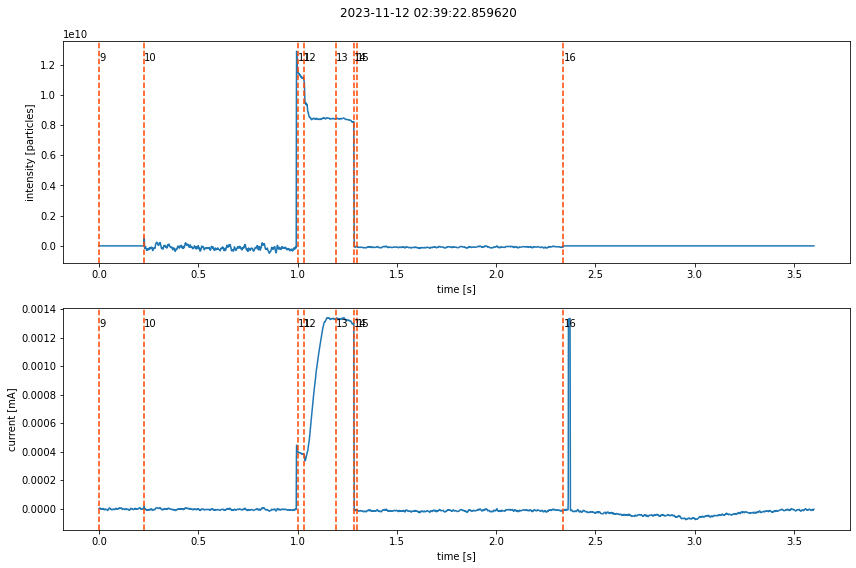

In [25]:
fig, (axIntensity, axCurrent) = plt.subplots(2,1,figsize=(12,8))
fig.suptitle(stamp2time(display_stamp))

axIntensity.plot(timing(np.arange(len(dcct_intensity))), dcct_intensity)
axCurrent.plot(timing(np.arange(len(dcct_current))), dcct_current)

# show beam processes
for pid, loc, _ in processIndices:
    axIntensity.axvline(timing(loc),
          linestyle="dashed", color="orangered")
    
    axCurrent.axvline(timing(loc),
          linestyle="dashed", color="orangered")
    
    axIntensity.text(timing(loc), 0.95*max(dcct_intensity), str(pid))
    axCurrent.text(timing(loc), 0.95*max(dcct_current), str(pid))

# make nice
axIntensity.set_xlabel("time [s]")
axIntensity.set_ylabel("intensity [particles]")

axCurrent.set_xlabel("time [s]")
axCurrent.set_ylabel("current [mA]")

fig.tight_layout()

# debug